## Análisis de datos - Clase 5

### Técnicas avanzadas para el tratamiento de datos faltantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### Identificamos datos faltantes

In [2]:
# Cargamos el dataset de Titanic de Seaborn
titanic_df = sns.load_dataset('titanic')
titanic_df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [3]:
titanic_df.isna().sum()[titanic_df.isna().sum() > 0] # columnas con datos faltantes

age            177
embarked         2
deck           688
embark_town      2
dtype: int64

### Tratamiento de datos faltantes

#### Imputación - Métodos multivariados

Cuando tengo datos MAR con patrones claros

* KNN (*K-Nearest Neighbors*)

Cuando tengo datos MAR con patrones complejos
* MICE (*Multiple Imputation by Chained Equations*)

In [4]:
# Creo una copia reducida del dataset original
titanic_2 = titanic_df[['age', 'pclass', 'sex', 'embarked']].copy() #hacemos una copia reducida del dataset original
titanic_2.head()

,age,pclass,sex,embarked
0,22.0,3,male,S
1,38.0,1,female,C
2,26.0,3,female,S
3,35.0,1,female,S
4,35.0,3,male,S


In [5]:
titanic_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       714 non-null    float64
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   embarked  889 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 28.0+ KB


#### a) Imputación con KNN

In [6]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
# Prerrequisitos para cualquier modelo - Necesitamos hacer encoding de las variables categóricas

le_sex = LabelEncoder() 
le_embarked = LabelEncoder()

# Codificamos las categóricas 
titanic_2['sex'] = le_sex.fit_transform(titanic_2['sex'])
titanic_2['embarked'] = le_embarked.fit_transform(titanic_2['embarked'].fillna(titanic_2['embarked'].mode()[0]))  # Antes de codificar, imputo con la moda, porque esta variable también tiene nulos (solo 2)

titanic_2.head()

,age,pclass,sex,embarked
0,22.0,3,1,2
1,38.0,1,0,0
2,26.0,3,0,2
3,35.0,1,0,2
4,35.0,3,1,2


In [8]:
# Prerequisito para KNNImputer: escalamiento

scaler = MinMaxScaler()
titanic_2_escalado = scaler.fit_transform(titanic_2)

In [9]:
# Definimos el modelo
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Aplicamos la imputación
titanic_escalado_imputado_knn = pd.DataFrame(
    knn_imputer.fit_transform(titanic_2_escalado),
    columns=titanic_2.columns,
    index=titanic_2.index
)

# "Desescalamos" los datos imputados
titanic_imputado_knn = pd.DataFrame(
    scaler.inverse_transform(titanic_escalado_imputado_knn),
    columns=titanic_2.columns,
    index=titanic_2.index
)

# Postprocesamiento del dataset imputado (decodificación)
titanic_imputado_knn['pclass'] = titanic_imputado_knn['pclass'].astype(int)
titanic_imputado_knn['sex'] = le_sex.inverse_transform(titanic_imputado_knn['sex'].astype(int))
titanic_imputado_knn['embarked'] = le_embarked.inverse_transform(titanic_imputado_knn['embarked'].astype(int))
titanic_imputado_knn['age'] = titanic_imputado_knn['age'].clip(lower=0)

print(f"Dataset imputado con KNN (postprocesado):\n {titanic_imputado_knn.head()}")

Dataset imputado con KNN (postprocesado):
     age  pclass     sex embarked
0  22.0       3    male        S
1  38.0       1  female        C
2  26.0       3  female        S
3  35.0       1  female        S
4  35.0       3    male        S


In [10]:
# miro las observaciones que fueron imputadas
df_compara = pd.concat([titanic_2['age'], titanic_imputado_knn], axis=1)
df_compara.columns = ['age_original', 'age_imputada', 'pclass', 'sex', 'embarked']
df_compara.head(20)

,age_original,age_imputada,pclass,sex,embarked
0,22.0,22.0,3,male,S
1,38.0,38.0,1,female,C
2,26.0,26.0,3,female,S
3,35.0,35.0,1,female,S
4,35.0,35.0,3,male,S
5,NaN,19.9,3,male,Q
6,54.0,54.0,1,male,S
7,2.0,2.0,3,male,S
8,27.0,27.0,3,female,S
9,14.0,14.0,2,female,C


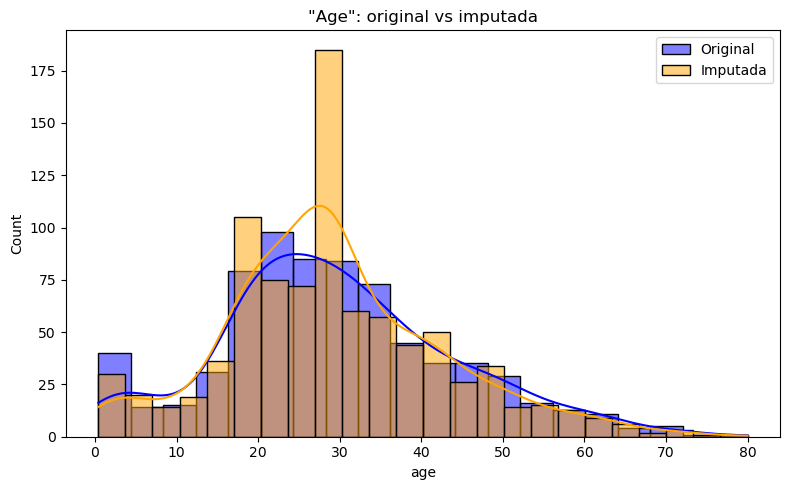

In [11]:
# Visualizar datos originales vs imputados (por ejemplo con el primer dataset imputado)
plt.figure(figsize=(8, 5))

# Age distribution
sns.histplot(titanic_2['age'], label='Original', kde=True, color='blue', alpha=0.5)
sns.histplot(titanic_imputado_knn['age'], label='Imputada', kde=True, color='orange', alpha=0.5)
plt.title('"Age": original vs imputada')
plt.legend()

plt.tight_layout()
plt.show()


#### b) Imputación con MICE

In [12]:
from statsmodels.imputation import mice

In [13]:
# Prerequisito para MICE con OLS: escalamiento

scaler = StandardScaler()
titanic_3_escalado = scaler.fit_transform(titanic_2)

titanic_3_escalado

array([[-0.53037664,  0.82737724,  0.73769513,  0.58595414],
       [ 0.57183099, -1.56610693, -1.35557354, -1.9423032 ],
       [-0.25482473,  0.82737724, -1.35557354,  0.58595414],
       ...,
       [        nan,  0.82737724, -1.35557354,  0.58595414],
       [-0.25482473, -1.56610693,  0.73769513, -1.9423032 ],
       [ 0.15850313,  0.82737724,  0.73769513, -0.67817453]])

In [14]:
# Definimos el modelo
imp = mice.MICEData(pd.DataFrame(titanic_3_escalado, columns=titanic_2.columns))

# Armamos los modelos para imputar
imp.set_imputer('age', formula='C(pclass) + sex + embarked', model_class=sm.OLS) # OLS es el modelo por defecto, hay muchos más

In [15]:
# Aplicar la imputación - generar 10 datasets imputados
imp.update_all(n_iter=10)

# Extraer el dataset imputado resultante (de la última iteración de MICE)
titanic_imp_mice_raw = imp.data.copy()
print(f"Dataset resultante (codificado):\n {titanic_imp_mice_raw.head()}\n\n")

# Este dataset es el que voy a "decodificar" (volver a las variables originales)
titanic_imputado_mice = imp.data.copy()

Dataset resultante (codificado):
         age    pclass       sex  embarked
0 -0.530377  0.827377  0.737695  0.585954
1  0.571831 -1.566107 -1.355574 -1.942303
2 -0.254825  0.827377 -1.355574  0.585954
3  0.365167 -1.566107 -1.355574  0.585954
4  0.365167  0.827377  0.737695  0.585954




In [16]:
# Desescalar el dataset imputado para visualizarlo
titanic_imputado_mice= scaler.inverse_transform(titanic_imputado_mice)
titanic_imputado_mice = pd.DataFrame(titanic_imputado_mice, columns=titanic_imp_mice_raw.columns)

titanic_imputado_mice.head()

,age,pclass,sex,embarked
0,22.0,3.0,1.0,2.0
1,38.0,1.0,0.0,0.0
2,26.0,3.0,0.0,2.0
3,35.0,1.0,0.0,2.0
4,35.0,3.0,1.0,2.0


In [17]:
titanic_imputado_mice.isna().sum()

age         0
pclass      0
sex         0
embarked    0
dtype: int64

In [18]:
# Postprocesar el dataset imputado para visualizarlo
titanic_imputado_mice['pclass'] = titanic_imputado_mice['pclass'].astype(int)
titanic_imputado_mice['sex'] = le_sex.inverse_transform(titanic_imputado_mice['sex'].astype(int))
titanic_imputado_mice['embarked'] = le_embarked.inverse_transform(titanic_imputado_mice['embarked'].astype(int))
titanic_imputado_mice['age'] = titanic_imputado_mice['age'].clip(lower=0)

print(f"Dataset imputado y postprocesado:\n {titanic_imputado_mice.head()}")


Dataset imputado y postprocesado:
     age  pclass     sex embarked
0  22.0       3    male        S
1  38.0       1  female        C
2  26.0       3  female        S
3  35.0       1  female        S
4  35.0       3    male        S


Nota: el valor típico de n_iter que se suele utilizar es entre 5 y 20 iteraciones. Se pueden aumentar si el dataset tiene dependencias muy complejas y el porcentaje de faltantes es alto (por ej >30%).

Visualizamos el dataset original y el imputado:

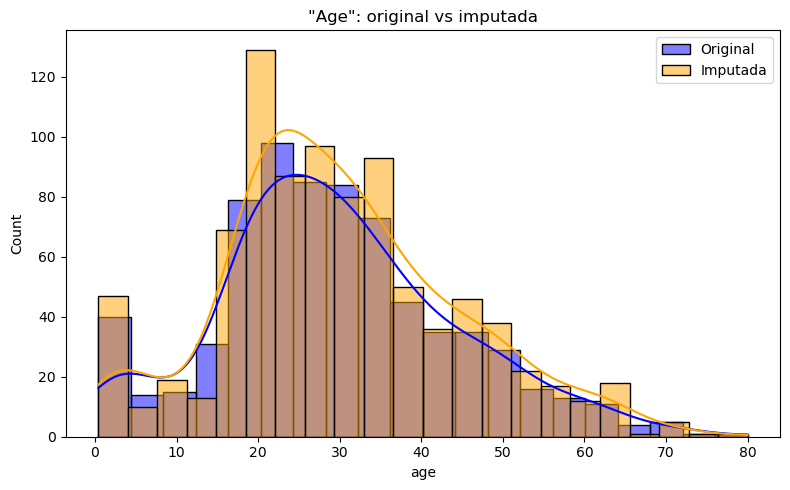

In [19]:
# Visualizar datos originales vs imputados (por ejemplo con el primer dataset imputado)
plt.figure(figsize=(8, 5))

# Age distribution
sns.histplot(titanic_2['age'], label='Original', kde=True, color='blue', alpha=0.5)
sns.histplot(titanic_imputado_mice['age'], label='Imputada', kde=True, color='orange', alpha=0.5)
plt.title('"Age": original vs imputada')
plt.legend()


plt.tight_layout()
plt.show()



Observación: como Statsmodels permite crear múltiples versiones del dataset imputado, por ejemplo:

```python
# Podemos generar distintas versiones del dataset imputado, para hacer un análisis de sensibilidad
titanic_imputados = [titanic_mar_imputado] + [imp.next_sample() for _ in range(4)]
```
Esos datasets se pueden usar luego para hacer un análisis de sensibilidad.